# Computer Vision (911.908)

## <font color='crimson'>Vision Transformers (ViT) & Attention</font>

**Changelog**

- Sep. 2023: first version
- Jan. 2026: minor fixes

---


In this lecture, we are going to look at a very recent influential architecture, the so called **Vision Transformer (ViT)**, an adaptation of Transformers (common to NLP tasks) for computer vision problems.


<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: #31708f; background-color: #d9edf7; border-color: #bce8f1;">
Credits: much of this implementation is an annotated version of the ViT implementation of Phil Wang on 
    <a href="https://github.com/lucidrains/vit-pytorch">GitHub</a>.
</div>

---


The key reference is:

[Dosovitskiy21a]     
**An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale**    
Dosovitskiy et al., ICLR 2021    
[arXiv](https://arxiv.org/abs/2010.11929)

In [1]:
from IPython.display import IFrame

In [2]:
IFrame("./Dosovitskiy21a.pdf", width=600, height=300)

Further, we will have to take a closer look at the seminal *Attention is all you need* paper, as the attention mechanism introduced there is an essential component the (Vision) Transformer architecture.

[Vaswani17a]    
**Attention is all you need**    
Vaswani et al., NIPS 2017       
[arXiv](https://arxiv.org/abs/1706.03762)

In [3]:
IFrame("./Vaswani17a.pdf", width=600, height=300)

## Imports

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn
from PIL import Image

import numpy as np

import torchvision
torchvision.disable_beta_transforms_warning() # as we are using v2 below (which is in beta state)
from torchvision.transforms import v2

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In the following, we will work through all the parts of the architecture (and the key concepts) on one example. Then, we will (1) consolidate all parts, tie them up in one class that implements the whole architecture, and (2) eventually train a ViT-based image classifier on the CIFAR10 dataset.

## Components

Let's load our **favorite** demo image first. We call this image $\mathbf{x} \in \mathbb{R}^{H\times W\times C}$.

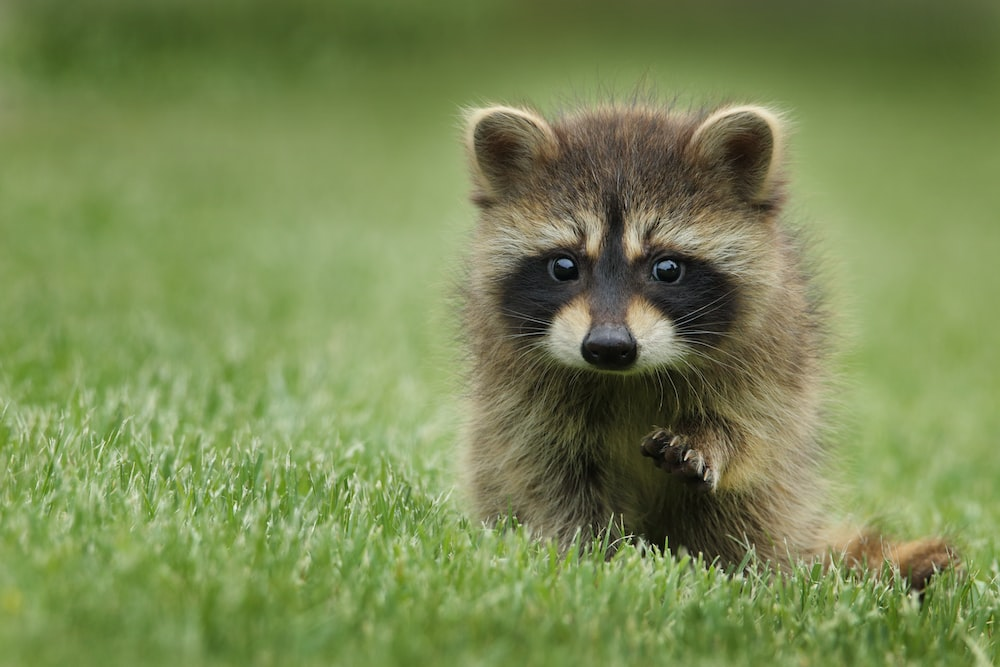

In [5]:
img = Image.open('./racoon.jpg')
img

### Patch extraction

When looking at Fig. 1 in [Dosovitskiy21a] (left), we see that we need to first split the image up into patches. These patches will essentially play the role of *tokens* (e.g., a word) in NLP (natural language processing) tasks. 

For demonstration, we first scale our input image to $256 \times 256$ pixel and write a transform that will give us a floating point tensor (float32) of size `BxCxWxH` where `B` is the batch size (here 1), `C` is the number of channels (here 3) and `W,H` will be 256 (as we just resized).

In [6]:
img256 = img.resize((256, 256)) # we resize here, but could do this as part of the transforms
tf = v2.Compose([v2.PILToTensor(),
                 v2.ToDtype(torch.float32)])
img256 = tf(img256).unsqueeze(0)
print(img256.shape)

torch.Size([1, 3, 256, 256])


Next, let us look at splitting the image into non-overlapping patches and linearly mapping each patch to a vector representation. The dimensionality of that representation is one parameter of the overall approach. In our demo case, we will split the image into `32x32` pixel patches. Overall, given the image size (here 256 times 256), we will have **64** patches overall. Upon vectorizing each patch (into a 1024-dimensional vector, i.e., $32 \times 32$), we will linearly map the patch to a 48-dimensional representation space ($\mathbb{R}^{48})$. 

Formally, as mentioned in section 3.1 of [Dosovitskiy21a], we take $\mathbf{x}$ of width $W$, height $H$ and $C$ channels and split the image into patches $\mathbf{x}_p \in \mathbb{R}^{N\times (P^2C)}$, where $P$ denotes the edge length of the (square) patches with $N=HW/P^2$. These patches are linearly/affinely mapped to $\mathbb{R}^D$.

To implement this step, we use `einops` to obtain the patches, `nn.Linear` for the linear/affine map and `nn.LayerNorm` to normalize the input and output to the linear layer. Here, the layer normalization (see [Ba16a](https://arxiv.org/abs/1607.06450)) (1) normalizes each of the $D$ dimensions by subtracting the mean and dividing by the standard deviation (computed over a minibatch), followed by a learnable scaling and shifting.

In [14]:
patch_width, patch_height = 32, 32
patch_dim = patch_width*patch_height*3 # i.e., Nx(P^2*C) with N=1 in our example
dim = 48

emb_layer = nn.Sequential(
    # see einops documentation https://einops.rocks/api/rearrange (and the PyTorch layer einops.layers.torch.Rearrange)
    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', 
              p1 = patch_height, 
              p2 = patch_width),
    nn.LayerNorm(patch_dim),
    nn.Linear(patch_dim, dim), # map to R^D
    nn.LayerNorm(dim))

patch_emb = emb_layer(img256)
batch_size, num_patches, _ = patch_emb.shape

print('Batch size: {:d}'.format(batch_size))
print('Number of patches: {:d}'.format(num_patches))
print('Output tensor shape of the full operation: ', patch_emb.shape)


Batch size: 1
Number of patches: 64
Output tensor shape of the full operation:  torch.Size([1, 64, 48])


As we can also see from Fig. 1 of [Dosovitskiy21a], we will also prepend an additional (learnable) representation that will encode the class token (this can later be used as an image representation once we obtain the transformer output, see below). So, overall, in our example, we have 64 vectors that come from linearly mapping the image patches **and** one vector that encodes the class.

In [16]:
cls_token = torch.randn(1, 1, dim) # will be a nn.Parameter later (as we seek to learn it)
cls_tokens = repeat(cls_token, '1 1 d -> b 1 d', b = batch_size)
print(batch_size)
print(cls_token)

1
tensor([[[-0.1187, -0.6357,  0.1438, -0.9299, -0.1907,  0.1561,  0.8658,
           1.1473, -1.2177, -0.1945,  0.8350, -1.5011,  1.4269, -1.2290,
           0.6005, -0.8695, -0.8214,  0.8517, -0.3659, -0.6854, -0.4180,
           0.2641,  1.4296, -0.8842,  0.3929, -0.4899,  0.3444, -0.3212,
          -2.1442,  0.5965,  0.2209,  2.8321, -2.7669, -0.9363,  1.1855,
          -0.3036, -1.0775,  1.1837,  0.6317,  1.1284,  0.1188,  0.5450,
          -0.0719, -0.8544,  0.3081, -1.2412,  0.6845, -0.3008]]])


Furthermore, we add a learnable **positional encoding**. This could be prescribed, but it can also be learned. Essentially, we are just adding another vector to each patch representation. The idea is to encode the position of each patch in the image, as this information would essentially be lost otherwise.

In [20]:
pos_embedding = torch.randn(1, num_patches + 1, dim) # will be a nn.Parameter later

# prepending the class token embedding
x = torch.cat((cls_tokens, patch_emb), dim=1)

# adding the position embedding
x = x + pos_embedding[:,:(num_patches+1)]

print(x.shape) # batch of size 1 with 65 embeddings of dimensionality 48

torch.Size([1, 65, 48])


### Attention

We now shift our focus to the right part of Fig. 1. that shows the **encoder** part of a transformer architecture. Input to this part are the 65 (in our example, as we have 64 patches + the class token) vectors we obtained from the previous steps. Key to implementing this encoder is to understand the **(multi-head) attention** module, which is an incarnation of the **scaled dot-product attention** mechanism from [Vaswani17a] (see paper linked above).

Quoting from [Vaswani17a]: *An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.*

In ViTs, we have a special case of attention called **self attention** where keys, queries and values are the same. 


#### Single-Head Attention

In the simplest case of only one attention head, we have three tensors: $\mathbf{Q},\mathbf{K},\mathbf{V} \in \mathbb{R}^{B \times M \times D}$ which hold our patch embeddings (i.e., these tensors are all the same in self attention). First, we multiple the queries with the keys

$$\mathbf{Q}\mathbf{K}^\top \in \mathbb{R}^{B \times M \times M}$$

where the transpose of $\mathbf{K}$ (i.e., $\mathbf{K}^\top$) is to be understood as transposing the last two dimensions. Upon scaling this tensor by $\sqrt{D}$ and applying a $\text{softmax}$ to the last dimension of the tensor, we obtain for each of the $M$ embeddings (i.e., one per batch, see above) a $M$-dimensional probability vector, i.e.,

$$ \text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{D}} \right)\in \mathbb{R}^{B \times M \times M}$$

Once we multiply the output of this operation with the "values" $\mathbf{V}$, we get 

$$ \text{softmax}\left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{D}} \right)\mathbf{V}\in \mathbb{R}^{B \times M \times D}$$

In this manner, attention allows, per patch embedding, to incorporate information about all other patch embeddings, i.e., we can learn to attend to important/relevant parts of the image (see "intuition" later on).

#### Multi-Head Attention

The idea of multi-head attention is to not just use one attention function, but use multiple. In order to retain the dimensionality of the output in $\mathbb{R}^{B \times M \times D}$, we are not going to use $\mathbf{Q},\mathbf{K},\mathbf{V}$ directly, but linearly project into a lower-dimensional space $d$ (in the paper, you have $d_k$ for keys and queries and $d_v$ for values). Each attention head gets its own projection matrix, i.e., for the $i$-th attention head we compute

$$ \text{softmax}\left( \frac{\mathbf{Q}\mathbf{W}_i^Q(\mathbf{K}\mathbf{W}^K_i)^\top}{\sqrt{d}} \right)(\mathbf{V}\mathbf{W}_i^V)\in \mathbb{R}^{B \times M \times d}$$

Concatenating the outputs of each attention head then yields the final output $\in \mathbb{R}^{B \times M \times H\cdot d}$.

### Interlude: Intuition of using inner products + softmax

<BarContainer object of 6 artists>

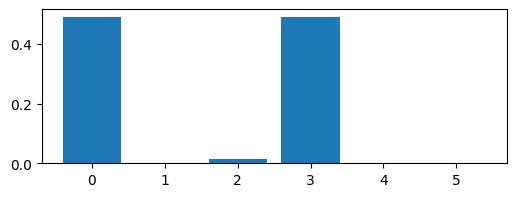

In [22]:
# let's create a random vector
a = torch.randn(1,10)
# ... and a matrix of six additional random vectors
b = torch.randn(6,10)
# we also set the 4th (index 3) element of b to a + noise (so, same direction + some noise)
b[3] = a + torch.randn(10)*1e-6 
b[0] = a + torch.randn(10)*1e-6
# next we compute the dot products between a and ALL elements of b -> shape [1,6]
B = torch.mm(a,b.T)
# and finally the softmax
softmax_output = torch.nn.functional.softmax(B,1).flatten().numpy()
plt.figure(figsize=(6,2))
plt.bar(np.arange(6),softmax_output)

In [23]:
softmax_output

array([4.9218044e-01, 1.7422695e-04, 1.5454405e-02, 4.9217996e-01,
       7.1915106e-06, 3.7732261e-06], dtype=float32)

We can see, since the `a` and the fourth element of `b` are very **similar** (by design here), we get a hight *weight* for the fourth element.

In [15]:
num_heads = 8
inner_dim = 64 *  num_heads
to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

# chunk up into queries, keys and values
qkv = to_qkv(x).chunk(3, dim=-1)

# rearrange to account for multiple heads in the following matrix multiplication
q,k,v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = num_heads), qkv)

dots = torch.matmul(q, k.transpose(-1, -2))
attn = torch.softmax(dots, dim=-1)
out = torch.matmul(attn, v)
out = rearrange(out, 'b h n d -> b n (h d)')
out.shape

torch.Size([1, 65, 512])

### Implementing the Transformer Encoder

Let's **clear** all variables.

In [17]:
%reset -f
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn
from PIL import Image
import numpy as np

import torchvision
torchvision.disable_beta_transforms_warning() # as we are using v2 below (which is in beta state)
from torchvision.transforms import v2

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

The following attention class implements the idea sketched above and also contains a final projection step, where we ensure that the output of the attention module (in case of multiple heads) is of dimensionality $D$.

In [18]:
class Attention(nn.Module):
    def __init__(self, 
                 dim,            # dimension of input vectors
                 heads = 8,      # number of attention heads
                 dim_head = 64,  # internal dimensionality of each head
                 dropout = 0.    # use dropout (in (0,1)) or not, i.e., 0.
                ):

        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

Next, we implement the MLP module as described in section 3.1. of [Dosovitskiy21a].

In [19]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

We are now prepared to implement the transformer encoder.

In [20]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

## Vision Transformer (ViT)

Finally, we can combine all components. 

Note that the output of the final block in the transformer stack will yield an output of size 
$\mathbb{R}^{B \times M \times D}$. To obtain **one** representation per batch element, we have multiple choices. The first choice is to use the representation of the class token, another choice is to average over all patch representations. The "pooling" step can be selected in the code via `pool=cls` or `pool=mean`.

In [21]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learnable!!!!
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

## Training/Testing on CIFAR10

For this demonstration, we do *not* pre-train on a substantially larger dataset and then finetune, but rather train directly on the CIFAR10 dataset.

In [23]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

classes = ('plane', 
           'car', 
           'bird', 
           'cat',
           'deer', 
           'dog', 
           'frog', 
           'horse', 
           'ship', 
           'truck')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [04:38<00:00, 612kB/s]


In [51]:
n_epochs = 200
DEVICE = 'cuda:0'
model = ViT(image_size=32, 
          patch_size=4, 
          num_classes=10, 
          dim=128, 
          depth=6, 
          heads=8, 
          mlp_dim=256,
          dropout=0.1,
          emb_dropout=0.1).to(DEVICE)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

print('#parameters', np.sum([s.numel() for s in model.parameters()]))

for epoch in range(n_epochs):
    
    total_train, correct_train = 0, 0
    
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()        
    
    total_test, correct_test = 0, 0

    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    print('{:5d} | Train-Err: {:.4f} | Test-Err: {:0.4f}'.format(
        epoch, 
        100.0 - 100 * correct_train / total_train,
        100.0 - 100 * correct_test / total_test))

    scheduler.step()

#parameters 4225258
    0 | Train-Err: 63.3280 | Test-Err: 52.1600
    1 | Train-Err: 50.5740 | Test-Err: 44.9500
    2 | Train-Err: 46.4080 | Test-Err: 42.8400
    3 | Train-Err: 42.9180 | Test-Err: 39.5700
    4 | Train-Err: 41.0180 | Test-Err: 38.7100
    5 | Train-Err: 38.9940 | Test-Err: 36.8700
    6 | Train-Err: 37.1460 | Test-Err: 34.0900
    7 | Train-Err: 35.2100 | Test-Err: 33.4500
    8 | Train-Err: 33.3980 | Test-Err: 31.8800
    9 | Train-Err: 32.0060 | Test-Err: 30.1000
   10 | Train-Err: 30.6060 | Test-Err: 29.4100
   11 | Train-Err: 29.1400 | Test-Err: 28.4500
   12 | Train-Err: 27.7040 | Test-Err: 27.4600
   13 | Train-Err: 26.4780 | Test-Err: 26.5100
   14 | Train-Err: 25.3520 | Test-Err: 27.2200
   15 | Train-Err: 24.3440 | Test-Err: 24.6900
   16 | Train-Err: 23.4020 | Test-Err: 25.5500
   17 | Train-Err: 22.5640 | Test-Err: 23.4700
   18 | Train-Err: 21.6940 | Test-Err: 22.9200
   19 | Train-Err: 21.1600 | Test-Err: 22.8000
   20 | Train-Err: 20.3000 | Test-Err: 2

  177 | Train-Err: 0.8940 | Test-Err: 15.4500
  178 | Train-Err: 1.0540 | Test-Err: 15.9100
  179 | Train-Err: 0.9560 | Test-Err: 16.7500
  180 | Train-Err: 0.8960 | Test-Err: 15.8400
  181 | Train-Err: 1.0200 | Test-Err: 15.8700
  182 | Train-Err: 0.9300 | Test-Err: 15.6900
  183 | Train-Err: 0.9360 | Test-Err: 15.6400
  184 | Train-Err: 0.9880 | Test-Err: 15.5100
  185 | Train-Err: 0.9440 | Test-Err: 15.7800
  186 | Train-Err: 0.9020 | Test-Err: 15.5200
  187 | Train-Err: 0.8760 | Test-Err: 16.2600
  188 | Train-Err: 0.9720 | Test-Err: 15.7800
  189 | Train-Err: 0.8600 | Test-Err: 16.3200
  190 | Train-Err: 0.9300 | Test-Err: 15.5900
  191 | Train-Err: 0.8900 | Test-Err: 15.6500
  192 | Train-Err: 0.9160 | Test-Err: 15.5700
  193 | Train-Err: 0.8780 | Test-Err: 15.8800
  194 | Train-Err: 0.7760 | Test-Err: 15.2400
  195 | Train-Err: 0.9140 | Test-Err: 16.5700
  196 | Train-Err: 0.8700 | Test-Err: 16.5200
  197 | Train-Err: 0.8400 | Test-Err: 15.4200
  198 | Train-Err: 0.8820 | Test-E